#Importing the data files

In [ ]:
import scipy.io

#importing the testing and training datasets
train_data = scipy.io.loadmat('train_data.mat')
test_data = scipy.io.loadmat('test_data.mat')

#test train split of the training and testing data
X_train = train_data['x']
X_test = test_data['x']

#print(train_data.keys())
#print(test_data.keys())

y_train = train_data['y']
y_train = y_train.ravel()
y_test = test_data['y']
y_test = y_test.ravel()

0.0


#Normalization of training data

In [ ]:
#vectorizing the dataset into a 784 dimension data
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

#calculating mean and standard deviation for all observations
import numpy as np

mi = np.mean(X_train, axis=0)
si = np.std(X_train, axis=0)

normalized_X_train = (X_train - mi) / si
normalized_X_test = (X_test - mi)/si

#Principal Component Analysis (PCA)

In [ ]:
#we center the data for computing the covariance matrix
centered_X_train = normalized_X_train - np.mean(normalized_X_train, axis=0)

#computing the covariance matrix
cov_matrix = np.cov(centered_X_train, rowvar=False)  #each column is a variable and row is a sample

#eigen value decomposition
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

#we sort the eigenvectors and values so that the top principal components correspond to the largest eigenvalues
sorted_index = np.argsort(eigenvalues)[::-1]
eigenvalues_sorted = eigenvalues[sorted_index]
eigenvectors_sorted = eigenvectors[:, sorted_index]

k = 50
principal_components_matrix = eigenvectors_sorted[:, :k]   #identifying the first k principal components

#Using PCA to reduce dimension and visualizing the data

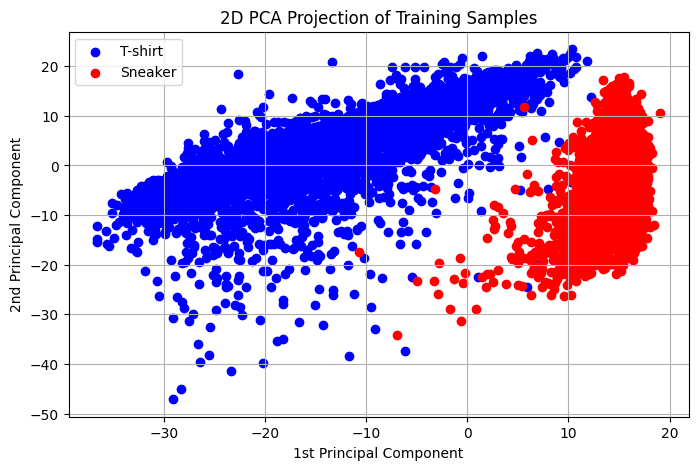

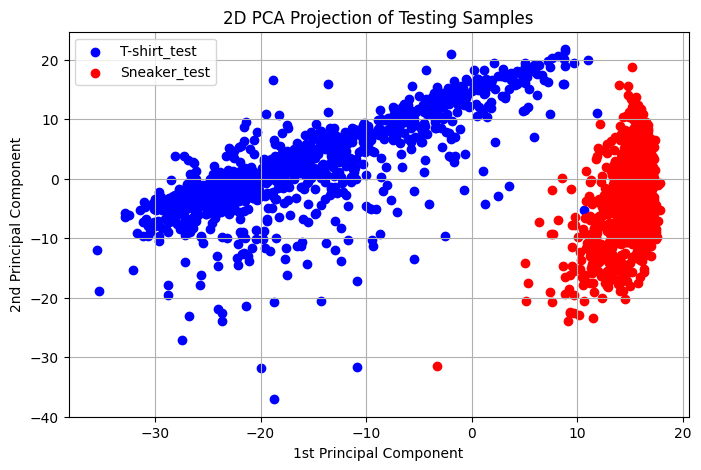

In [ ]:
#projecting the data onto 2D plane using first two principal components
X_train_2D = centered_X_train.dot(principal_components_matrix[:, :2])

centered_X_test = normalized_X_test - np.mean(normalized_X_train, axis = 0)
X_test_2D = centered_X_test.dot(principal_components_matrix[:, :2])

import matplotlib.pyplot as plt

# Scatter plot for the two classes in the training set

#visualizing the training set
plt.figure(figsize=(8, 5))
class_0 = X_train_2D[y_train == 0]    #we select rows where y_train is 0
class_1 = X_train_2D[y_train == 1]    #we select rows where y_train is 1
plt.scatter(class_0[:, 0], class_0[:, 1], color='blue', label='T-shirt')    #2D coordinates for class "T-shirt"
plt.scatter(class_1[:, 0],class_1[:, 1], color='red', label='Sneaker')     #2D coordinates for class "Sneaker"

plt.xlabel('1st Principal Component')
plt.ylabel('2nd Principal Component')
plt.title('2D PCA Projection of Training Samples')
plt.legend()
plt.grid(True)
plt.show()

#visualizing the testing set
plt.figure(figsize=(8, 5))
class_0 = X_test_2D[y_test == 0]    #we select rows where y_train is 0
class_1 = X_test_2D[y_test == 1]    #we select rows where y_train is 1
plt.scatter(class_0[:, 0], class_0[:, 1], color='blue', label='T-shirt_test')      #2D coordinates for class "Tshirt"
plt.scatter(class_1[:, 0], class_1[:, 1], color='red', label='Sneaker_test')       #2D coordinates for class "Sneaker"

plt.xlabel('1st Principal Component')
plt.ylabel('2nd Principal Component')
plt.title('2D PCA Projection of Testing Samples')
plt.legend()
plt.grid(True)
plt.show()

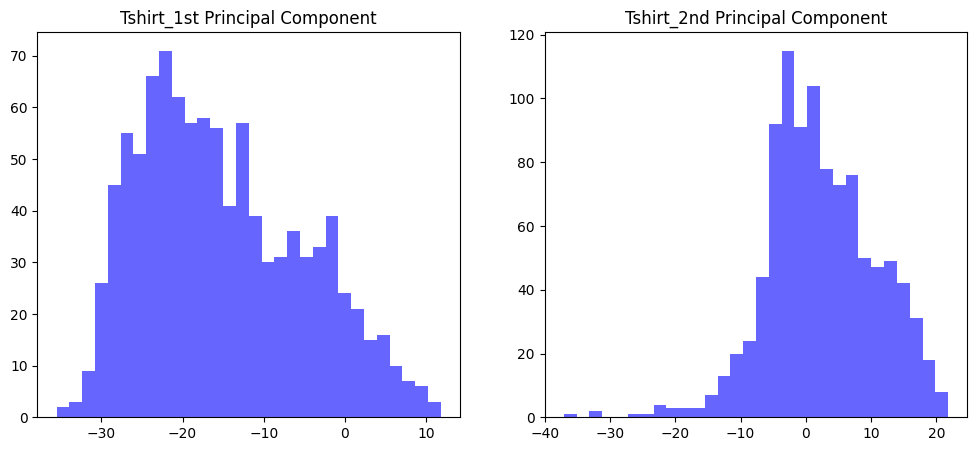

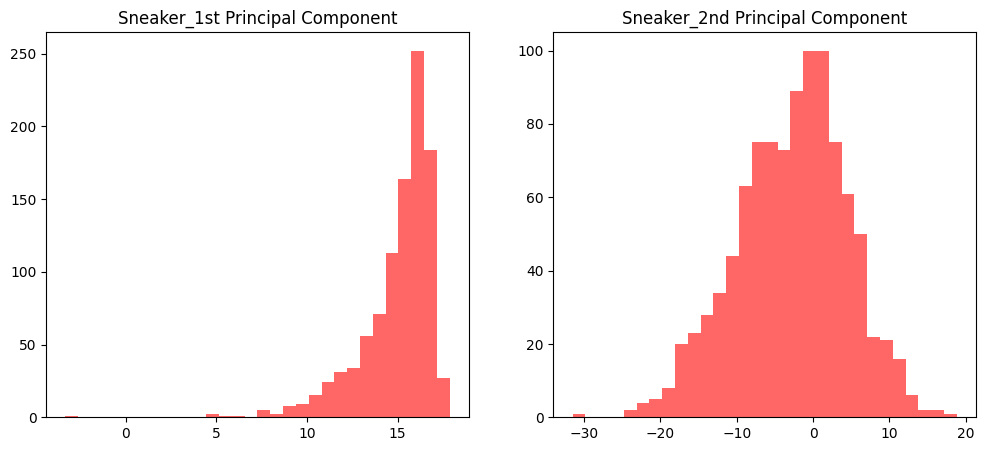

In [ ]:
#Histogram plot for Tshirt(class 0)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(class_0[:, 0], bins=30, color='blue', alpha=0.6)
plt.title("Tshirt_1st Principal Component")

plt.subplot(1, 2, 2)
plt.hist(class_0[:, 1], bins=30, color='blue', alpha=0.6)
plt.title("Tshirt_2nd Principal Component")
plt.show()

#Histogram plot for Sneaker (class 1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(class_1[:, 0], bins=30, color='red', alpha=0.6)
plt.title("Sneaker_1st Principal Component")

plt.subplot(1, 2, 2)
plt.hist(class_1[:, 1], bins=30, color='red', alpha=0.6)
plt.title("Sneaker_2nd Principal Component")
plt.show()

#Parameter estimation

In [ ]:
#we first split the training samples on the basis of labels (0 for T-shirt, 1 for Sneaker)
X_train_2D_tshirt = X_train_2D[y_train == 0]
X_train_2D_sneaker = X_train_2D[y_train == 1]

mean_tshirt = np.mean(X_train_2D_tshirt, axis=0)
mean_sneaker = np.mean(X_train_2D_sneaker, axis=0)

cov_tshirt = np.cov(X_train_2D_tshirt, rowvar=False)
cov_sneaker = np.cov(X_train_2D_sneaker, rowvar=False)

print("Mean for T-shirt class:", mean_tshirt)
print("Mean for Sneaker class:", mean_sneaker)
print("Covariance matrix for T-shirt class:\n", cov_tshirt)
print("Covariance matrix for Sneaker class:\n", cov_sneaker)

Mean for T-shirt class: [-14.96013579   2.53759713]
Mean for Sneaker class: [14.96013579 -2.53759713]
Covariance matrix for T-shirt class:
 [[103.38209995  69.15661464]
 [ 69.15661464  73.43418283]]
Covariance matrix for Sneaker class:
 [[ 4.94656978  6.78163691]
 [ 6.78163691 54.67473161]]


#Minimum error rate classification

In [ ]:
# Gaussian PDF function for a 2D point

#this function calculates the likelihood of the observation based on mean and covariance (parameters that we estimated)
def gaussian_likelihood(x, mean, cov):

    size = len(mean)
    det = np.linalg.det(cov)    #determinant of the covariance matrix
    norm_const = 1.0 / (np.power((2 * np.pi), size / 2) * np.sqrt(det))     #first term in the gaussian probability density function (before exponent)
    inv = np.linalg.inv(cov)     #calculating the inverse of the covariance matrix
    result = np.exp(-0.5 * ((x - mean).T @ inv @ (x - mean)))     #the second term i.e the exponential term in the gaussian probability density function

    return norm_const * result

#function to classify based on likelihoods
def classify(sample, mean_tshirt, cov_tshirt, mean_sneaker, cov_sneaker):

    #estimate the likelihoods of both the classes
    likelihood_tshirt = gaussian_likelihood(sample, mean_tshirt, cov_tshirt)
    likelihood_sneaker = gaussian_likelihood(sample, mean_sneaker, cov_sneaker)

    if likelihood_tshirt > likelihood_sneaker:
      return 0    #return 0 if class is tshirt

    else:
      return 1    #return 1 if class is sneakers


#we classify the samples in the training data set
train_predictions = [classify(x, mean_tshirt, cov_tshirt, mean_sneaker, cov_sneaker) for x in X_train_2D]     #prediction of classes

#calculation of accuracy (we compare the predicted samples with the true labels)
train_accuracy = np.mean(np.array(train_predictions) == y_train)
print(f"Training Accuracy: {train_accuracy * 100:2f}%")

#we classify the samples in the testing data set
test_predictions = [classify(x, mean_tshirt, cov_tshirt, mean_sneaker, cov_sneaker) for x in X_test_2D]       #prediction of classes

#calculation of accuracy (we compare the predicted samples with the true labels)
test_accuracy = np.mean(np.array(test_predictions) == y_test)
print(f"Testing Accuracy: {test_accuracy * 100:2f}%")

Training Accuracy: 99.750000%
Testing Accuracy: 99.900000%
